## Setup

In [ ]:
! brew install git python3 cmake sdl2 sdl2_image sdl2_ttf sdl2_gfx boost boost-python3
! python3 -m pip install --upgrade pip setuptools psutil wheel

In [ ]:
! pip install gfootball 

In [ ]:
! pip install setuptools==65.5.0
! git clone https://github.com/google-research/football.git
! cd football && pip install . 

### Test game play

In [127]:
! python -m gfootball.play_game --action_set=full

objc[81026]: Class SDLApplication is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368800) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321287e8). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLAppDelegate is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x106368850) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x132128838). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLTranslatorResponder is implemented in both /opt/homebrew/Cellar/sdl2/2.26.3/lib/libSDL2-2.0.0.dylib (0x1063688c8) and /Users/georgipachov/opt/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1321288b0). One of the two will be used. Which one is undefined.
objc[81026]: Class SDLMessageBoxPresenter is implemented in both /opt/h

### Learning environment 

In [69]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import numpy as np
import os
from collections import namedtuple
import gfootball
import gfootball.env as football_env
from gfootball.env.wrappers import Simple115StateWrapper
import collections

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
        
def obs_transform(obs):
    return Simple115StateWrapper.convert_observation(obs, True)


def create_env(render=False, 
               env_name='academy_empty_goal', 
               wrapper_init=None,
               record=True,
               **params):
    if env_name == 'cart_pole':
        env = gym.make('CartPole-v0')
    else:
        env_names = ['1_vs_1_easy', '5_vs_5', 'academy_run_to_score', 'academy_empty_goal_close', 'academy_empty_goal']
        os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
        env = football_env.create_environment(env_name=env_name, 
                                              stacked=False, 
                                              representation='raw',
                                              rewards='scoring,checkpoints',
                                              logdir='replays', 
                                              write_goal_dumps=record, 
                                              write_full_episode_dumps=record, 
                                              write_video=record,
                                              render=render)
        if wrapper_init is not None:
            return wrapper_init.__call__(env)
        else:
            return env


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(115, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 19)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


def select_action(model, state, in_training):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()
        
    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    return action.item()


def finish_episode(model, optimizer, gamma, eps=1e-8):
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


### Learning objective: Run to score with keeper

In [80]:
class DistanceFromOpponentGoalReward(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self._env = env
        
        def step(self, action):
            obs, reward, done, info = self._env.step(action)
            reward = 0
            
            obs = obs[0]

            bx, by, bz = obs['ball']
            ogx, ogy = -1, 0
            
            dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
            reward -= dist_from_opponent_goal
            
            return obs, reward, done, info
        

class DistanceFromOpponentGoalRewardFixed(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self._env = env
        self._last_ball_pos = [0, 0, 0]

    def step(self, action):
        obs, reward, done, info = self._env.step(action)
        reward = 0

        obs = obs[0]
        goals_left_team = obs['score'][0]

        reward += goals_left_team * 100000
        lost_ball = obs['ball_owned_team'] == 1
        if lost_ball:
            reward -= 10000

        # Penalty for not moving the ball
        if np.all(obs['ball'] == self._last_ball_pos):
            reward -= 1000
        self._last_ball_pos=obs['ball']
        
        bx, by, bz = obs['ball']
        ogx, ogy = 1, 0

        # Negative penalty if far from goal
        dist_from_opponent_goal = (np.sqrt((bx-ogx)**2 + (by-ogy)**2))
        reward -= dist_from_opponent_goal

        # Negative time penalty
        reward -= 1

        return obs, reward, done, info

In [71]:
def run_agent(exp_name='exp1',
              model=None,
              train=True,
              render=False,
              record=False, 
              num_episodes=2000,
              num_steps=500,
              task='academy_empty_goal_close',
              wrapper_init=DistanceFromOpponentGoalReward,
              policy_fn=Policy,
              solved_threshold=-25,
              log_every=50,
              learning_rate=1e-2,
              gamma=0.99,
              last_n=5,
              seed=0,
              checkpoint=True,
              checkpoint_dir='checkpoints'
             ):
    # set seed first
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if not train:
        model.eval()
                
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    
    try: 
        max_reward = -1_000_000
        running_reward = 0
        episode_rewards = []
        env = create_env(render=render, 
                         env_name=task,
                         record=record,
                         wrapper_init=wrapper_init)
        if model is None:
            model = policy_fn()
            
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        # eps = np.finfo(np.float32).eps.item()
        eps = 1e-8

        for i_episode in range(num_episodes):
            # reset environment and episode reward
            state = env.reset()
            state = obs_transform(state)
            ep_reward = 0

            # for each episode, only run 9999 steps so that we don't 
            # infinite loop while learning
            for t in range(1, num_steps):

                # select action from policy
                action = select_action(model, state, train)

                # take the action
                state, reward, done, _ = env.step(action)
                state = obs_transform([state])

                model.rewards.append(reward)
                ep_reward += reward
                if done:
                    break

                    
            # log results
            episode_rewards.append(ep_reward)
            
            # update cumulative reward
            running_reward = np.mean(episode_rewards[-last_n:])
            
            if i_episode % log_every == 0:
                print(f'Episode: {i_episode}\tLast reward: {ep_reward:.2f} \t Last {last_n} episodes average reward: {running_reward}')

            if train:
                # save checkpoint
                if checkpoint:
                    if running_reward > max_reward:
                        torch.save(model, f'{checkpoint_dir}/{running_reward}_{task}_{exp_name}_checkpoint_{i_episode}.h5')
                        max_reward = running_reward

                if i_episode > last_n and running_reward > solved_threshold:
                    torch.save(model, f'{task}_{exp_name}.h5')
                    print('Solved!')
                    return model, episode_rewards
                
                else:
                    # perform backprop
                    finish_episode(model, optimizer, gamma)
                
        return model, episode_rewards
    finally: 
        env.close()
        
def load_best_agent(checkpoints_dir='checkpoints'):
    # Load best agent
    checkpoints = os.listdir(checkpoints_dir)
    all_checkpoints = {int(x[:x.index('.')]):x for x in checkpoints}
    max_reward = max(all_checkpoints.keys())
    best = all_checkpoints[max_reward]
    print('Loading checkpoint: ', best)
    model_loaded = torch.load(os.path.join(checkpoints_dir, best))
    return model_loaded

def load_agent(name, checkpoints_dir='checkpoints'):
    # Load manually
    print('Loading checkpoint: ', name)
    model_loaded = torch.load(os.path.join(checkpoints_dir, name))
    return model_loaded

### 3 vs 1 with keeper

Episode: 0	Last reward: -73.94 	 Last 20 episodes average reward: -73.9401617746456


/var/folders/4x/vb5tl80s45v2f_k7_zb004bc0000gn/T/ipykernel_226/2607901590.py:126: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))


Episode: 100	Last reward: -10028.90 	 Last 20 episodes average reward: -16040.122187788322
Episode: 200	Last reward: -10018.76 	 Last 20 episodes average reward: -8034.277323314987
Episode: 300	Last reward: -10023.74 	 Last 20 episodes average reward: -26034.6434399496
Episode: 400	Last reward: -54.04 	 Last 20 episodes average reward: -15543.267165150744
Solved!


<AxesSubplot: title={'center': 'Mean reward for last 20 episodes'}, xlabel='Еpisode', ylabel='Reward'>

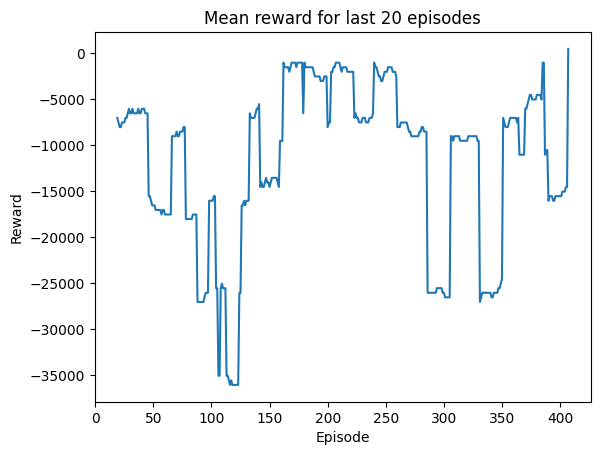

In [93]:
last_n=20
model, episode_rewards = run_agent(train=True,
                                   render=False,
                                   record=False,
                                   log_every=100,
                                   num_steps=50,
                                   num_episodes=2000,
                                   seed=42,
                                   last_n=last_n,
                                   solved_threshold=0, 
                                   task='academy_3_vs_1_with_keeper', 
                                   learning_rate=1e-1,
                                   wrapper_init=DistanceFromOpponentGoalRewardFixed)
pd.Series(episode_rewards).rolling(last_n).mean().plot(xlabel='Еpisode', ylabel='Reward', title='Mean reward for last 20 episodes')

In [94]:
run_agent(model=model, 
          train=False, 
          render=False, 
          record=False,
          seed=42, 
          num_episodes=100,
          task='academy_3_vs_1_with_keeper', 
          wrapper_init=DistanceFromOpponentGoalRewardFixed)

Episode: 0	Last reward: -10037.56 	 Last 5 episodes average reward: -10037.559568757191
Episode: 50	Last reward: -64.56 	 Last 5 episodes average reward: -740212.8083568886


(Policy(
   (affine1): Linear(in_features=115, out_features=128, bias=True)
   (action_head): Linear(in_features=128, out_features=19, bias=True)
   (value_head): Linear(in_features=128, out_features=1, bias=True)
 ),
 [-10037.559568757191,
  -10031.505967253797,
  -10029.726453465639,
  99938.18123204348,
  -1650385.874872106,
  -10027.828882108384,
  -10043.851286053226,
  -81.91487630195759,
  -10027.980217873856,
  -10025.96002101724,
  99865.11015189531,
  -10018.779774170845,
  -10038.202542484316,
  -10016.021752355284,
  -10016.24778661755,
  -66.28357864099668,
  -1930458.760852603,
  -10058.055483275877,
  -50.045019491588555,
  -10036.180409507775,
  -10032.419413854685,
  -10029.437945632462,
  -10029.355708625564,
  -10016.22783467081,
  -10094.017660582287,
  -10022.96507588763,
  -10026.807943732701,
  -37.79597128087328,
  -10091.11240437367,
  -10043.380052714116,
  -10023.949255137006,
  -10018.997604318969,
  -10032.429953569053,
  -10042.803536416015,
  -10037.75576

In [148]:
# https://github.com/google-research/football/blob/master/gfootball/doc/observation.md#raw-observations

In [ ]:
# academy_empty_goal_close
# academy_empty_goal
# academy_run_to_score
# academy_run_to_score_with_keeper